# Challenge MDS 2016

LLT _ quick solution

# Import des données

Avant de rentrer dans le vif du sujet, importons quelques packages necessaires pour ce tutoriel :

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Librairie de visualisation super cool
import seaborn as sns # pip install seaborn

Les datasets sont sous format .csv. Vous pouvez les importer avec le code ci-dessous.

In [3]:
train = pd.read_csv('../data_challenge/boites_medicaments_train.csv',
                    encoding='utf-8',
                    sep=';')

test = pd.read_csv('../data_challenge/boites_medicaments_test.csv',
                   encoding='utf-8', 
                   sep=';')

In [4]:
pd.set_option("display.max_columns", 99) # permet de voir toutes les colonnes
train.head(10)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml,statut,etat commerc,agrement col,tx rembours,forme pharma,voies admin,statut admin,date declar annee,date amm annee,type proc,titulaires,substances,prix
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé pelliculé,orale,Autorisation active,2014,2014,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),DÉSOGESTREL,2.83
1,plaquette(s) thermoformée(s) aluminium de 28 c...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé à croquer,orale,Autorisation active,2013,2009,Procédure de reconnaissance mutuelle,TEVA SANTE,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",14.30
2,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,gélule à libération prolongée,orale,Autorisation active,2000,1996,Procédure nationale,MYLAN SAS,CHLORHYDRATE DE DILTIAZEM,5.66
3,30 sachet(s)-dose(s) papier aluminium complexe...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,granulés à libération prolongée,orale,Autorisation active,2005,2004,Procédure nationale,SANOFI AVENTIS FRANCE,"ACIDE VALPROÏQUE, VALPROATE DE SODIUM",24.27
4,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,non,100%,comprimé pelliculé,orale,Autorisation active,2015,2010,Procédure nationale,TEVA SANTE,LÉTROZOLE,59.94
5,plaquette(s) thermoformée(s) PVC-aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,100%,comprimé,orale,Autorisation active,2001,2000,Procédure nationale,EG LABO - LABORATOIRES EUROGENERICS,FLUTAMIDE,27.17
6,flacon(s) polyéthylène haute densité (PEHD) de...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,100,0.0,Présentation active,Déclaration de commercialisation,oui,100%,capsule molle,orale,Autorisation active,2015,2001,Procédure centralisée,EISAI (ROYAUME-UNI),BEXAROTÈNE,877.83
7,plaquette(s) thermoformée(s) PVC polyéthylène ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,oui,65%,comprimé,orale,Autorisation active,2006,2006,Procédure de reconnaissance mutuelle,SANDOZ,GLIMÉPIRIDE,6.58
8,plaquette(s) thermoformée(s) PVC-Aluminium de ...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0.0,Présentation active,Déclaration d'arrêt de commercialisation,oui,65%,comprimé sécable,orale,Autorisation active,2013,2002,Procédure nationale,ARROW GENERIQUES,MALÉATE D'ÉNALAPRIL,18.63
9,plaquette(s) polyamide aluminium PVC de 10 com...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0.0,Présentation active,Déclaration de commercialisation,non,65%,comprimé pelliculé,orale,Autorisation active,2015,2012,Procédure nationale,ARROW GENERIQUES,"CEFPODOXIME PROXÉTIL, CEFPODOXIME",6.13


On est maintenant pret a attaquer les choses serieuses ! :)

# Analyse descriptive

### Structure des datasets

Le dataset ```train``` comporte les caracteristiques et prix de 8564 boites de medicaments. C'est ce dataset que nous allons utiliser pour creer un modele.
Chaque boite de medicament est decrite par une observation de 41 variables. Ces variables sont decrites dans le fichier `Description.pdf` present dans la cle usb.

Le dataset ```test``` comporte les caracteristiques des 3671 boites de medicaments dont il faut predire le prix. A la difference de ```train```, le prix des boites de medicaments n'est bien sur pas inclus et une colonne `id` a ete ajoutée pour identifier les boites de medicaments pendant l'etape de soumission des predictions sur [Datascience.net](www.datascience.net)

### Distribution des donnees

Jetons maintenant un coup d'oeil a la distribution des donnees

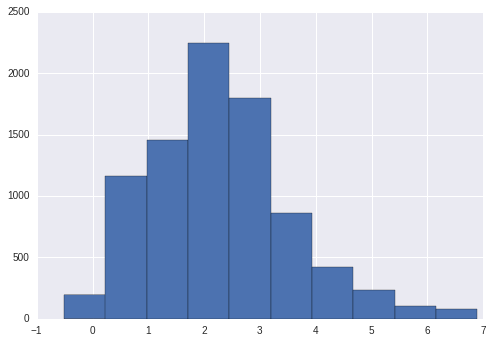

In [5]:
# Distribution du log des prix
# On prend le log des prix car sa distribution est plus proche d'une gaussienne
train['logprix'] = train['prix'].apply(np.log)
train['logprix'].hist()

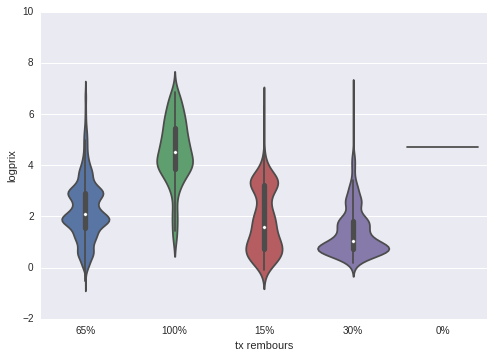

In [6]:
# Influence sur les prix de la feature "tx rembours"
sns.violinplot(y="logprix", x="tx rembours", data=train)

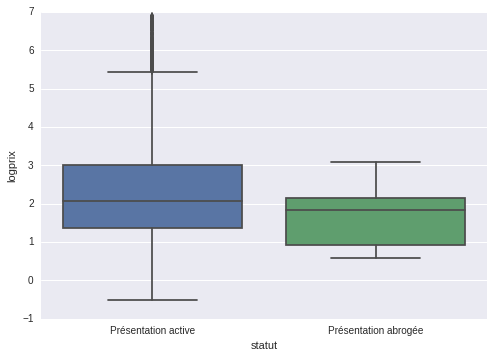

In [7]:
# Influence sur les prix de la feature "statut"
sns.boxplot(y="logprix", x="statut", data=train)

# Preparation des donnees

### Types de features

In [8]:
train['tx rembours']

0        65%
1        65%
2        65%
3        65%
4       100%
5       100%
6       100%
7        65%
8        65%
9        65%
10       65%
11       65%
12       65%
13       65%
14       65%
15       65%
16       15%
17       65%
18       65%
19       65%
20       65%
21       65%
22       65%
23       65%
24       65%
25       65%
26       65%
27       65%
28       65%
29       65%
        ... 
8534     30%
8535     65%
8536     65%
8537     65%
8538     15%
8539     65%
8540     15%
8541     65%
8542     65%
8543     65%
8544     65%
8545     65%
8546     65%
8547     65%
8548     65%
8549     65%
8550     65%
8551     65%
8552     65%
8553     65%
8554     65%
8555     15%
8556     65%
8557     65%
8558     65%
8559     65%
8560     65%
8561     65%
8562     65%
8563     65%
Name: tx rembours, dtype: object

In [9]:
# features numériques
feat_num = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule'] + ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml']
# features date
feat_dates = ['date declar annee', 'date amm annee']
# features catégorielles
feat_cat = ['statut', 'etat commerc', 'agrement col', 'tx rembours','voies admin', 'statut admin', 'type proc']

"""
feat_cat = ['statut', 'etat commerc', 'agrement col',
          'voies admin', 'statut admin', 'type proc']

feat_remb = ['tx rembours']
train['tx rembours'] = train['tx rembours'].str[:-1].astype(int)*0.01
test['tx rembours'] = test['tx rembours'].str[:-1].astype(int)*0.01

train.set_value(train['tx rembours'] == 0.00, 'tx rembours', -1.0)
train.set_value(train['tx rembours'] == 0.15, 'tx rembours', -0.5)
train.set_value(train['tx rembours'] == 0.30, 'tx rembours', 0.0)
train.set_value(train['tx rembours'] == 0.65, 'tx rembours', 0.5)
train.set_value(train['tx rembours'] == 1., 'tx rembours', 1.0)

test.set_value(test['tx rembours'] == 0.00, 'tx rembours', -1.0)
test.set_value(test['tx rembours'] == 0.15, 'tx rembours', -0.5)
test.set_value(test['tx rembours'] == 0.30, 'tx rembours', 0.0)
test.set_value(test['tx rembours'] == 0.65, 'tx rembours', 0.5)
test.set_value(test['tx rembours'] == 1., 'tx rembours', 1.0)
"""

# features texte
feat_text = ['libelle', 'titulaires', 'substances', 'forme pharma']

### Encodage des features catégorielles

Les algorithmes de machine learning s'attendent à avoir en entrée des nombres, et non pas des chaînes de caractères. C'est pourquoi nous transformons les features catégorielles en nombres, à l'aide de LabelEncoder()

In [10]:
for c in feat_cat:
    le = LabelEncoder()
    le.fit(train[c].append(test[c]))
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

In [11]:
allstr = ""
substances = pd.concat([train, test]).substances.values#.append(list(test.substances.values))

allsubs = []
for sub in list(set(substances)):
    allsubs.append(sub.split(", "))

allsubs = set([item.replace(" ","") for sublist in allsubs for item in sublist])
print len(allsubs) # Ca fait une liste des diverses substances

allsubs = pd.DataFrame(list(allsubs))# == "CHLORHYDRATED'HYDROMORPHONE"

#print train.substances
allPositions = []
for listSub in train.substances:
    #print listSub.replace(" ","").split(",")
    positions = np.zeros(len(allsubs), dtype=np.bool)
    for thissub in listSub.replace(" ","").split(","):
        positions = positions | ((allsubs == thissub).values.transpose()[0])
        #print np.sum(positions)
    allPositions.append(positions)
    #sys.exit()
allPosTrain = allPositions
print len(train)

allPositions = []
for listSub in test.substances:
    #print listSub.replace(" ","").split(",")
    positions = np.zeros(len(allsubs), dtype=np.bool)
    for thissub in listSub.replace(" ","").split(","):
        positions = positions | ((allsubs == thissub).values.transpose()[0])
        #print np.sum(positions)
    allPositions.append(positions)
    #sys.exit()
testPos = pd.DataFrame(allPositions)
allPosTest = allPositions

print "done"

1915
8564
done


In [12]:
pd.Index(np.arange(len(train)))
trainPos = pd.DataFrame(allPosTrain, index=pd.Index(np.arange(len(train))))
train = pd.concat([train, trainPos], axis=1)

pd.Index(np.arange(len(test)))
testPos = pd.DataFrame(allPosTest, index=pd.Index(np.arange(len(test))))
test = pd.concat([test, testPos], axis=1)


In [13]:
feat_sub = trainPos.columns
#print list(feat_sub.values.astype(str))
print feat_num+feat_cat+feat_dates
FEATURES = feat_num+feat_cat+feat_dates+list(feat_sub.values.astype(int))
#print FEATURES
train[1]

['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 'libelle_tube', 'libelle_stylo', 'libelle_seringue', 'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 'libelle_gelule', 'libelle_film', 'libelle_poche', 'libelle_capsule', 'nb_plaquette', 'nb_ampoule', 'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue', 'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml', 'statut', 'etat commerc', 'agrement col', 'tx rembours', 'voies admin', 'statut admin', 'type proc', 'date declar annee', 'date amm annee']


0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
8534    False
8535    False
8536    False
8537    False
8538    False
8539    False
8540    False
8541    False
8542    False
8543    False
8544    False
8545    False
8546    False
8547    False
8548    False
8549    False
8550    False
8551    False
8552    False
8553    False
8554    False
8555    False
8556    False
8557    False
8558    False
8559    False
8560    False
8561    False
8562    False
8563    False
Name: 1, dtype: bool

# Creation d'un modele

Il est maintenant temps de creer un modele. Dans ce tutoriel nous allons construire une [Foret Aleatoire](https://fr.wikipedia.org/wiki/For%C3%AAt_d'arbres_d%C3%A9cisionnels)

Pour ce faire nous utilisons toutes les variables dont nous disposons, sauf les variables de type "texte".

Pour eviter le [surapprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) et estimer les vraies performances de notre modele nous allons utiliser le critère de [validation croisee](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) (cross-validation) methode k-fold.

### Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [14]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Cross validation

In [15]:
train["date declar annee"] = 2017 - train["date declar annee"]
test["date declar annee"] = 2017 - test["date declar annee"]
train["date amm annee"] = 2017 - train["date amm annee"]
test["date amm annee"] = 2017 - test["date amm annee"]


In [18]:
err = 0
NBROUND = 5
FEATURES = feat_num+feat_cat+feat_dates+list(feat_sub.values.astype(int)) # on n'utilise que ces features pour ce modèle basique
for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
    y = train['logprix']
    X = train[FEATURES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestRegressor(n_estimators=20, max_depth=47)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    print mape_error(np.exp(y_test), np.exp(pred))
print "*** MAPE Error : ", err / NBROUND

39.8789854064
40.5515201965
39.176466933
37.9290318646
36.6603897664
*** MAPE Error :  38.8392788334


Cela veut dire notre modele predit les prix des medicaments avec environ 65% d’erreur en moyenne. Par exemple, si un medicament vaut reellement 10€, notre prediction sera de 16.5€ (ou 3.5€).

In [ ]:
ePred = []
for iMax in np.arange(15)*2+10:
    err = 0
    NBROUND = 5
    FEATURES = feat_num+feat_cat+feat_dates+list(feat_sub.values.astype(int)) # on n'utilise que ces features pour ce modèle basique
    for train_index, test_index in KFold(train.shape[0], n_folds=NBROUND):
        y = train['logprix']
        X = train[FEATURES]
        X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestRegressor(n_estimators=iMax, max_depth=47)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        # ne pas oublier de reprendre l'exponentielle de la prédiction
        err += mape_error(np.exp(y_test), np.exp(pred))
        #print mape_error(np.exp(y_test), np.exp(pred))
    print "*** MAPE Error : ", err / NBROUND
    ePred.append(err / NBROUND)
plt.plot(ePred, label="error on target")
plt.xlabel("max_depth")
plt.legend()
plt.show()
plt.close()


# Calcul des predictions et soumission

In [23]:
clf = RandomForestRegressor(n_estimators=2000, max_depth=47)
# On entraine de nouveau le modèle, cette fois sur l'intégralité des données
clf.fit(train[FEATURES], train['logprix'])
predictions = np.exp(clf.predict(test[feat_num+feat_cat+feat_dates+list(feat_sub.values.astype(int))]))

In [24]:
pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv',  
                          header=['prix'],
                          sep = ';')

Vous etes maintenant pret ? Faites votre premiere soumission en uplodant le fichier `soumission.csv` sur [Datascience.net](www.datascience.net)

In [66]:
train["date declar annee"]

0       1.098612
1       1.386294
2       2.833213
3       2.484907
4       0.693147
5       2.772589
6       0.693147
7       2.397895
8       1.386294
9       0.693147
10      2.639057
11      1.609438
12      0.693147
13      1.386294
14      2.197225
15      3.583519
16      1.098612
17      2.708050
18      2.397895
19      2.564949
20      1.609438
21      1.098612
22      1.609438
23      3.583519
24      1.098612
25      1.386294
26      1.098612
27      3.044522
28      1.609438
29      1.791759
          ...   
8534    2.944439
8535    0.693147
8536    1.945910
8537    1.791759
8538    3.951244
8539    2.890372
8540    2.890372
8541    3.091042
8542    2.944439
8543    0.693147
8544    1.945910
8545    1.098612
8546    3.891820
8547    1.609438
8548    2.484907
8549    1.791759
8550    2.772589
8551    0.693147
8552    0.693147
8553    2.772589
8554    1.098612
8555    1.791759
8556    1.098612
8557    2.079442
8558    1.945910
8559    0.693147
8560    2.890372
8561    1.0986